# Proyek Akhir: Menyelesaikan Permasalahan HR Perusahaan Jaya Jaya Maju

- Nama: Jihad Rafsanjani
- Email: rafsanjanijihad@gmail.com
- Id Dicoding: jihadr

## Persiapan

### Menyiapkan library yang dibutuhkan

In [3]:
#Koneksi untuk Kaggle
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier



### Menyiapkan data yang akan diguankan

## Data Understanding

In [5]:
#Untuk notebook pada kaggle
#df = pd.read_csv('/kaggle/input/jayajayamaju/employee_data.csv')
df = pd.read_csv('employee_data.csv')

In [6]:
# Cek struktur data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement            1470 non-null   int64  
 14  JobLevel

In [7]:
# Cek missing values
df.isna().sum()

EmployeeId                    0
Age                           0
Attrition                   412
BusinessTravel                0
DailyRate                     0
Department                    0
DistanceFromHome              0
Education                     0
EducationField                0
EmployeeCount                 0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 0
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtC

In [8]:
# Cek duplikasi
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,EmployeeId,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1058.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,735.500000,36.923810,0.169187,802.485714,9.192517,2.912925,1.0,2.721769,65.891156,2.729932,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,424.496761,9.135373,0.375094,403.509100,8.106864,1.024165,0.0,1.093082,20.329428,0.711561,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,1.000000,18.000000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,368.250000,30.000000,0.000000,465.000000,2.000000,2.000000,1.0,2.000000,48.000000,2.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,735.500000,36.000000,0.000000,802.000000,7.000000,3.000000,1.0,3.000000,66.000000,3.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,1102.750000,43.000000,0.000000,1157.000000,14.000000,4.000000,1.0,4.000000,83.750000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,1470.000000,60.000000,1.000000,1499.000000,29.000000,5.000000,1.0,4.000000,100.000000,4.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


## Data Preparation / Preprocessing

In [10]:
#memisahkan data yang memiliki attrition dan tidak
# Data dengan label (untuk training & analisis)
df_labeled = df[df['Attrition'].notna()].copy()

# Data tanpa label (untuk prediksi)
df_unlabeled = df[df['Attrition'].isna()].copy()

print(df_labeled.shape)
print(df_unlabeled.shape)


(1058, 35)
(412, 35)


In [11]:
# Analisis faktor penyebab
df_labeled.groupby('OverTime')['Attrition'].mean()


OverTime
No     0.107856
Yes    0.319218
Name: Attrition, dtype: float64

In [12]:
# Cek kembali struktur
df_labeled.info()
df_unlabeled.info()

# Pastikan kolom sama (kecuali Attrition)
set(df_labeled.columns) - set(df_unlabeled.columns)


<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 1 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1058 non-null   int64  
 1   Age                       1058 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1058 non-null   object 
 4   DailyRate                 1058 non-null   int64  
 5   Department                1058 non-null   object 
 6   DistanceFromHome          1058 non-null   int64  
 7   Education                 1058 non-null   int64  
 8   EducationField            1058 non-null   object 
 9   EmployeeCount             1058 non-null   int64  
 10  EnvironmentSatisfaction   1058 non-null   int64  
 11  Gender                    1058 non-null   object 
 12  HourlyRate                1058 non-null   int64  
 13  JobInvolvement            1058 non-null   int64  
 14  JobLevel     

set()

In [13]:
#membuang kolom yang tidak diperlukan
drop_cols = ['StandardHours', 'EmployeeCount','Over18']
cat_cols = ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus','Gender']

df_labeled = df_labeled.drop(columns=drop_cols)
df_unlabeled = df_unlabeled.drop(columns=drop_cols)


In [14]:
#menyesuaikan type data
df_labeled['Attrition'] = df_labeled['Attrition'].astype(int)
df_labeled['EmployeeId'] = df_labeled['EmployeeId'].astype(object)


In [15]:
#Pemisahan kolom
TARGET = 'Attrition'

ordinal_cols = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TrainingTimesLastYear',
    'WorkLifeBalance'
]

continuous_cols = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
    'PercentSalaryHike', 'TotalWorkingYears',
    'YearsAtCompany', 'YearsInCurrentRole',
    'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

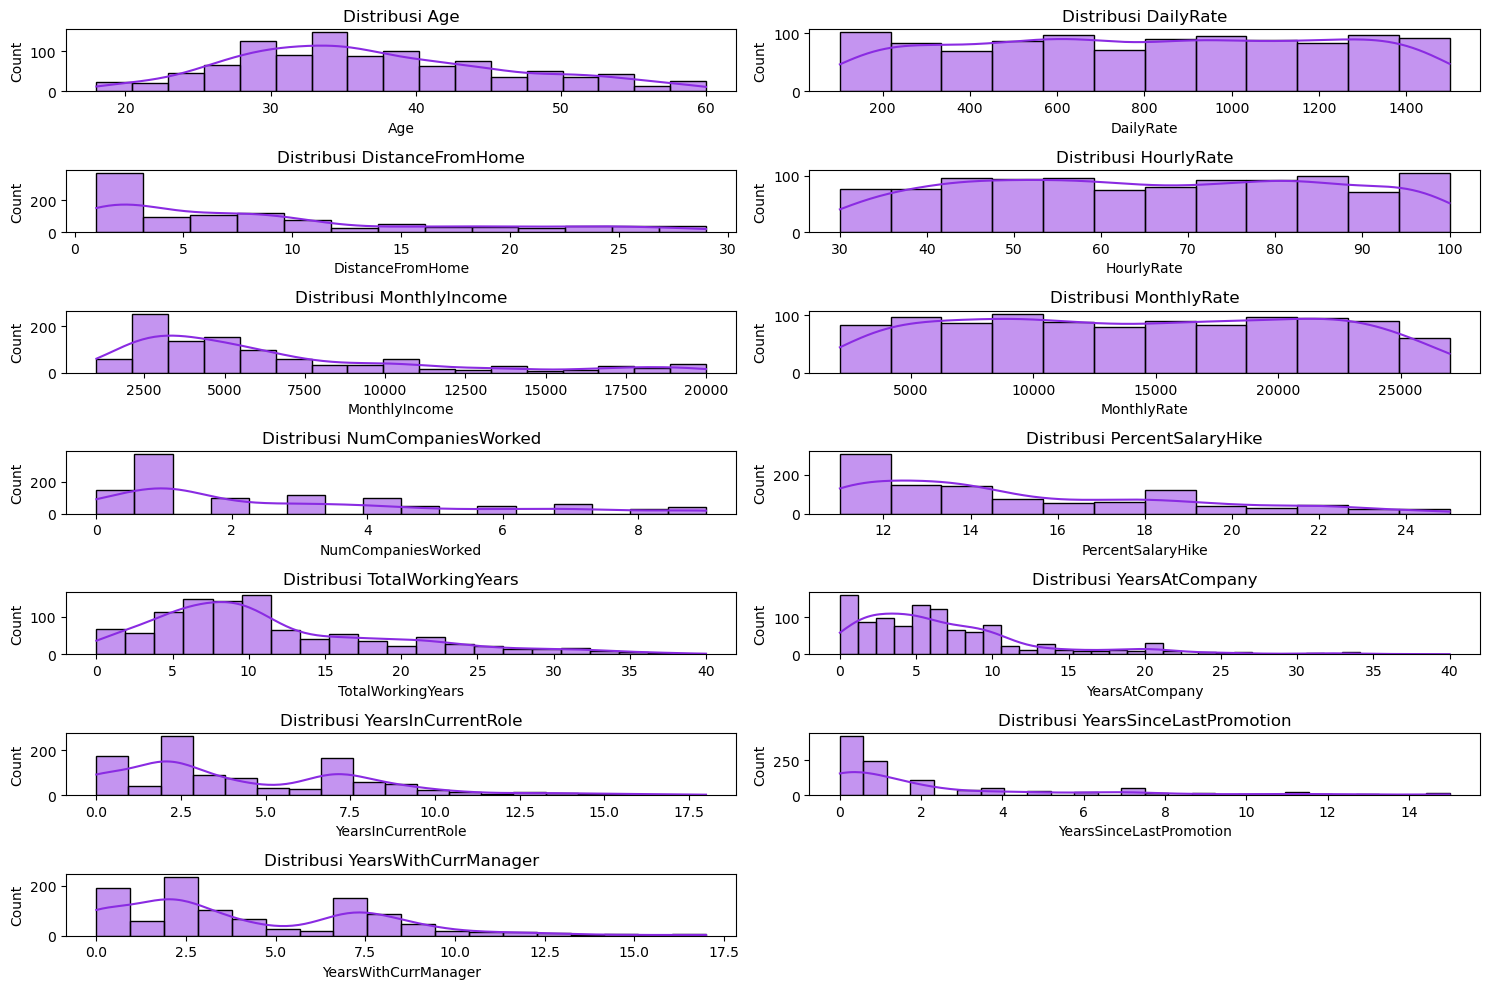

In [16]:
#cek distribusi fitur numerik

#num_cols = df_labeled.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(len(continuous_cols)//2 + 1, 2, i)
    sns.histplot(df_labeled[col], kde=True, color='blueviolet')
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

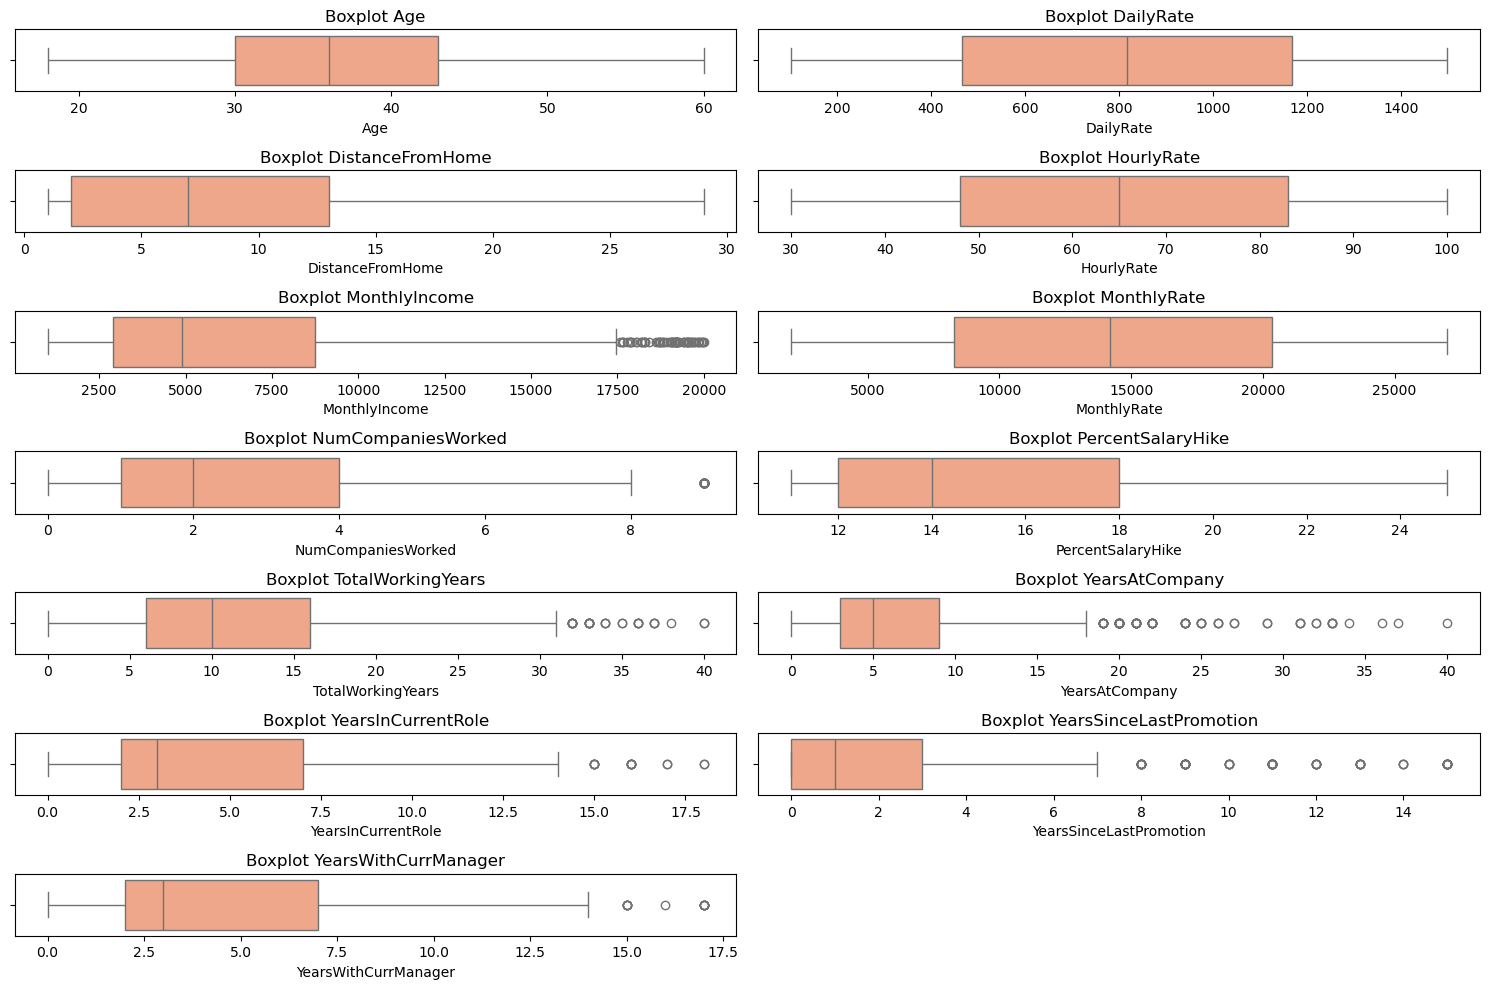

In [17]:
#Deteksi Outlier

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(len(continuous_cols)//2 + 1, 2, i)
    sns.boxplot(x=df_labeled[col], color='lightsalmon')
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

In [18]:
df_labeled.shape

(1058, 32)

In [19]:
df_unlabeled.shape

(412, 32)

In [20]:
df.shape

(1470, 35)

In [21]:
#outlier handling hanya du continous column

def cap_outlier(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower, upper)

for col in continuous_cols:
    cap_outlier(df_labeled, col)
    cap_outlier(df_unlabeled, col)


In [22]:
#scaling untuk numerik continous

scaler = StandardScaler()

df_labeled[continuous_cols] = scaler.fit_transform(
    df_labeled[continuous_cols]
)

df_unlabeled[continuous_cols] = scaler.transform(
    df_unlabeled[continuous_cols]
)

In [23]:
df_labeled, df_unlabeled = df_labeled.align(
    df_unlabeled,
    join='left',
    axis=1,
    fill_value=0
)


In [24]:
df_labeled = pd.get_dummies(
    df_labeled,
    columns=cat_cols,
    drop_first=False
)

df_unlabeled = pd.get_dummies(
    df_unlabeled,
    columns=cat_cols,
    drop_first=False
)


In [25]:
encoded_cat_cols = [
    col for col in df_labeled.columns
    if any(col.startswith(cat + '_') for cat in cat_cols)
]

In [26]:
#penggabungan
feature_cols = ordinal_cols + continuous_cols + encoded_cat_cols

X_labeled = df_labeled[feature_cols]
y_labeled = df_labeled[TARGET]

X_unlabeled = df_unlabeled[feature_cols]

In [27]:
#validasi
df_labeled[TARGET].value_counts()
df_labeled[ordinal_cols].nunique()


Education                   5
EnvironmentSatisfaction     4
JobInvolvement              4
JobLevel                    5
JobSatisfaction             4
PerformanceRating           2
RelationshipSatisfaction    4
StockOptionLevel            4
TrainingTimesLastYear       7
WorkLifeBalance             4
dtype: int64

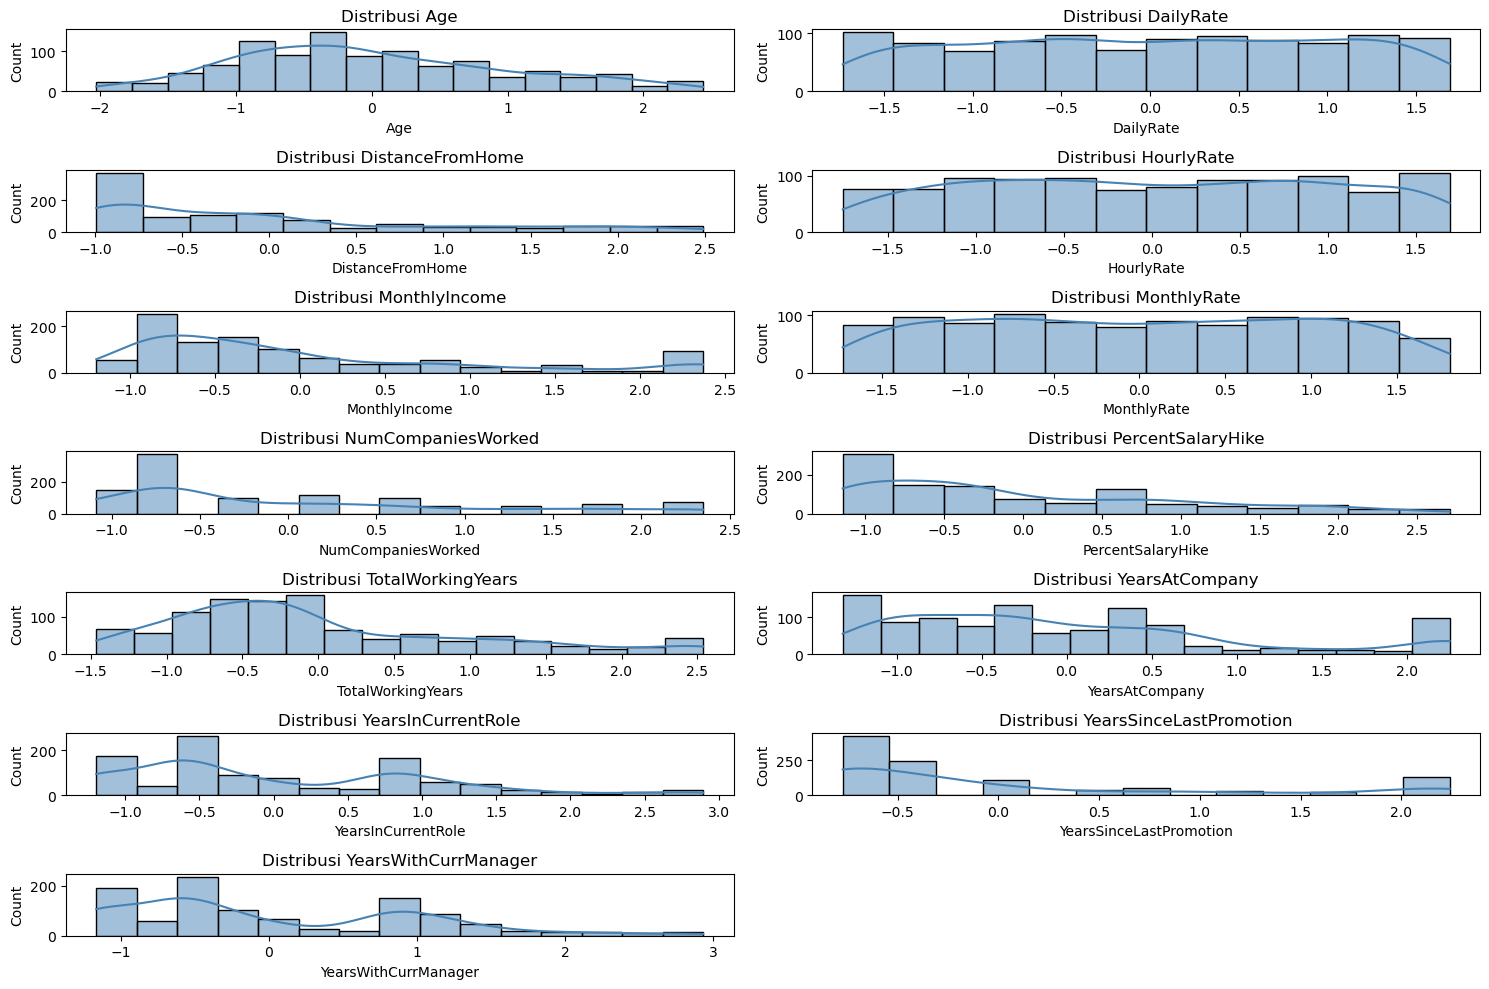

In [28]:
#cek distribusi fitur numerik

num_cols = df_labeled.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(len(continuous_cols)//2 + 1, 2, i)
    sns.histplot(df_labeled[col], kde=True, color='steelblue')
    plt.title(f'Distribusi {col}')
plt.tight_layout()
plt.show()

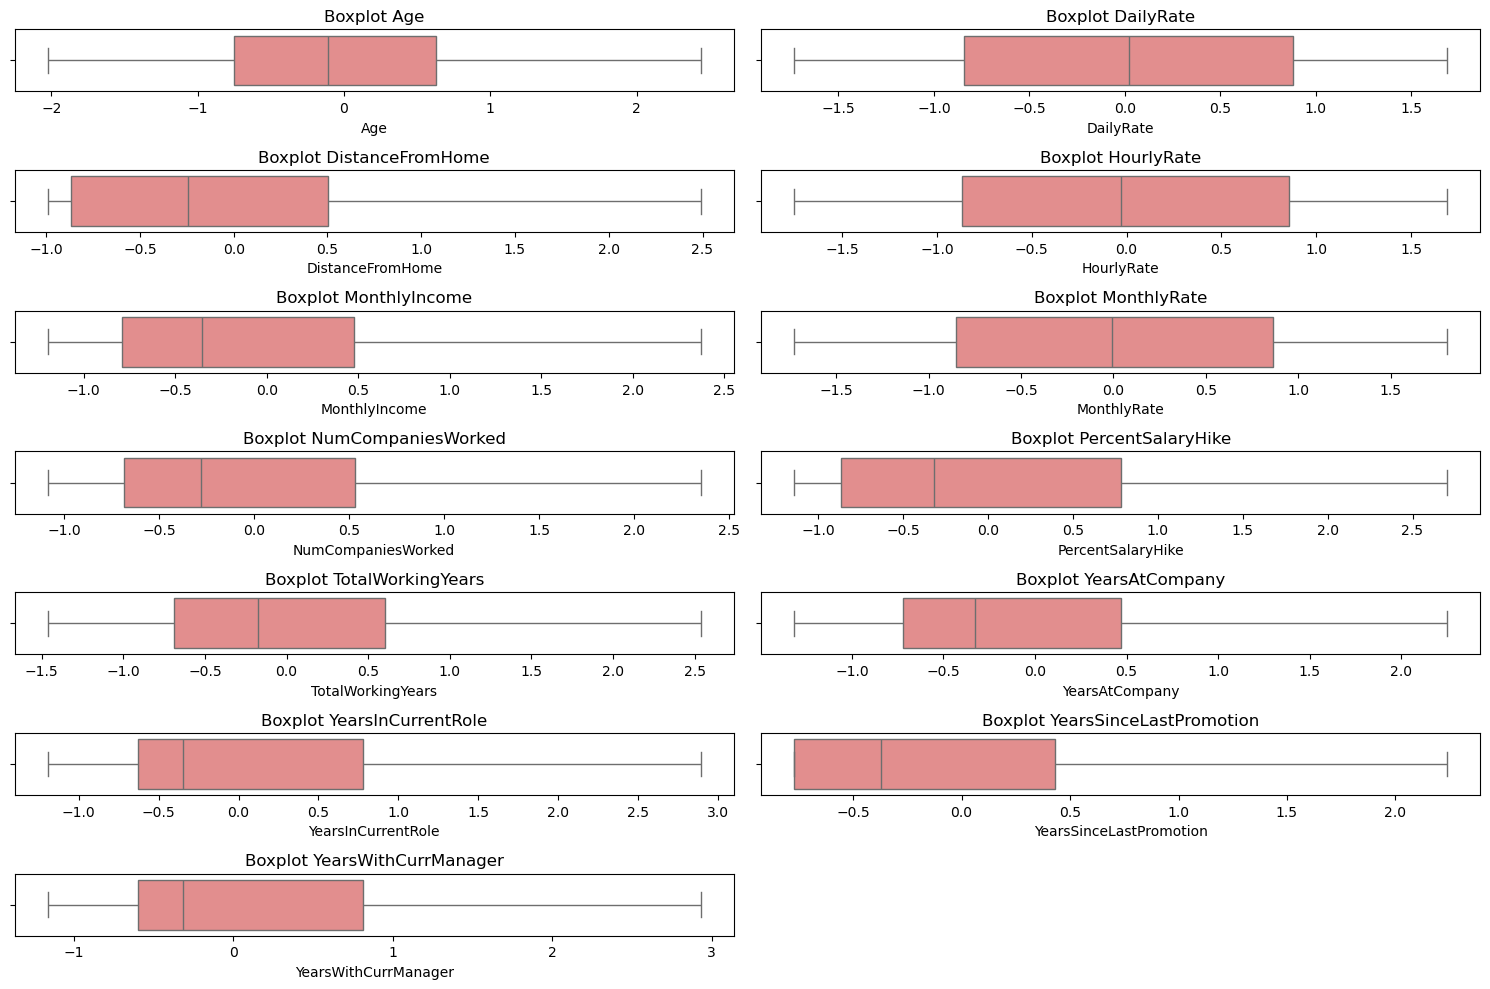

In [29]:
#Deteksi Outlier

plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(len(continuous_cols)//2 + 1, 2, i)
    sns.boxplot(x=df_labeled[col], color='lightcoral')
    plt.title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

In [30]:
df_labeled.value_counts('JobLevel')

JobLevel
1    394
2    364
3    165
4     80
5     55
Name: count, dtype: int64

In [31]:
df_labeled.head()

,EmployeeId,Age,Attrition,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Gender_Female,Gender_Male
1,2,-0.005929,1,0.811829,0.251560,2,1,-0.228580,1,2,...,False,False,False,False,False,False,True,False,True,False
2,3,1.482487,1,1.257596,-0.619433,4,1,-1.557631,3,1,...,False,False,True,False,False,False,True,False,False,True
3,4,0.525648,0,-0.623443,2.117973,3,3,0.559005,3,4,...,False,False,False,True,False,False,True,False,True,False
6,7,0.313018,0,0.770191,-0.992715,2,2,-0.425477,1,2,...,False,False,False,True,False,False,True,False,False,True
7,8,1.907749,1,-0.207067,-0.868288,3,4,0.608229,3,5,...,False,False,False,False,False,False,True,False,False,True


## Modeling

In [32]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(
    X_labeled,
    y_labeled,
    test_size=0.2,
    stratify=y_labeled,
    random_state=42
)


In [33]:
#Membuat model logistic regretions
logreg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'  # penting karena data imbalanced
)

logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [34]:
#Evaluasi hasil
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)


#menceetak evaluasi
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc)

              precision    recall  f1-score   support

           0       0.92      0.68      0.78       176
           1       0.30      0.69      0.42        36

    accuracy                           0.68       212
   macro avg       0.61      0.69      0.60       212
weighted avg       0.81      0.68      0.72       212

ROC AUC: 0.7493686868686869


In [35]:
#membangun Random Forest model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=5,
                       min_samples_split=10, n_estimators=300, random_state=42)

In [36]:
#Evaluasi model
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

#mencetak hasil evaluasi
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.86      0.95      0.91       176
           1       0.53      0.25      0.34        36

    accuracy                           0.83       212
   macro avg       0.70      0.60      0.62       212
weighted avg       0.81      0.83      0.81       212

ROC AUC: 0.7615214646464646


In [37]:
#membangun model Gradient boosting
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [38]:
#evaluasi model
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

#mencetak hasil evaluasi
print(classification_report(y_test, y_pred_gb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_gb))


              precision    recall  f1-score   support

           0       0.86      0.97      0.91       176
           1       0.62      0.22      0.33        36

    accuracy                           0.84       212
   macro avg       0.74      0.60      0.62       212
weighted avg       0.82      0.84      0.81       212

ROC AUC: 0.7414772727272727


In [39]:
#Membangun model XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))


              precision    recall  f1-score   support

           0       0.88      0.92      0.90       176
           1       0.50      0.39      0.44        36

    accuracy                           0.83       212
   macro avg       0.69      0.65      0.67       212
weighted avg       0.82      0.83      0.82       212

ROC AUC: 0.7476325757575757


In [41]:
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'ROC_AUC': [
        roc_auc_score(y_test, y_prob),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_gb),
        roc_auc_score(y_test, y_prob_xgb) if 'y_prob_xgb' in locals() else None
    ]
})

model_comparison


,Model,ROC_AUC
0,Logistic Regression,0.749369
1,Random Forest,0.761521
2,Gradient Boosting,0.741477
3,XGBoost,0.747633


In [43]:
#Perbandingan hasil evaluasi

def get_model_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        'Model': model_name,
        
        # Fokus utama: kelas 1 (Attrition)
        'Precision_Attrition': report['1']['precision'],
        'Recall_Attrition': report['1']['recall'],
        'F1_Attrition': report['1']['f1-score'],
        'Support_Attrition': report['1']['support'],
        
        # Tambahan informasi global
        'Accuracy': accuracy_score(y_true, y_pred),
        'Macro_F1': report['macro avg']['f1-score'],
        'Weighted_F1': report['weighted avg']['f1-score']
    }

results = []

# Logistic Regression
results.append(
    get_model_metrics(y_test, y_pred, 'Logistic Regression')
)

# Random Forest
results.append(
    get_model_metrics(y_test, y_pred_rf, 'Random Forest')
)

# Gradient Boosting
results.append(
    get_model_metrics(y_test, y_pred_gb, 'Gradient Boosting')
)

# XGBoost (jika ada)
if 'y_pred_xgb' in globals():
    results.append(
        get_model_metrics(y_test, y_pred_xgb, 'XGBoost')
    )


In [44]:
comparison_df = pd.DataFrame(results)

comparison_df


,Model,Precision_Attrition,Recall_Attrition,F1_Attrition,Support_Attrition,Accuracy,Macro_F1,Weighted_F1
0,Logistic Regression,0.304878,0.694444,0.423729,36.0,0.679245,0.600753,0.717656
1,Random Forest,0.529412,0.250000,0.339623,36.0,0.834906,0.622642,0.809541
2,Gradient Boosting,0.615385,0.222222,0.326531,36.0,0.844340,0.619265,0.812581
3,XGBoost,0.500000,0.388889,0.437500,36.0,0.830189,0.668750,0.821462



## Ringkasan ROC AUC (Kemampuan Membedakan Risiko)

---


| Model | ROC AUC | Interpretasi |
|-----|--------|-------------|
| Logistic Regression | 0.749 | Baik |
| Random Forest | **0.762** | Terbaik |
| Gradient Boosting | 0.741 | Baik |
| XGBoost | 0.748 | Baik |

---


###  Interpretasi Umum
- Seluruh model memiliki **ROC AUC ~0.74–0.76**, yang berarti:
  - Model mampu **membedakan karyawan keluar dan bertahan dengan cukup baik**
- Perbedaan ROC AUC antar model **relatif kecil**
  - Artinya, **model sederhana pun sudah cukup kompetitif**

---

##  Ringkasan Evaluasi Kualitas Model (Fokus Attrition)

| Model | Precision | Recall | F1-score | Accuracy |
|-----|-----------|--------|----------|----------|
| Logistic Regression | 0.30 | **0.69** | 0.42 | 0.68 |
| Random Forest | 0.53 | 0.25 | 0.34 | 0.83 |
| Gradient Boosting | **0.62** | 0.22 | 0.33 | **0.84** |
| XGBoost | 0.50 | 0.39 | **0.44** | 0.83 |

---

##  Kesimpulan per Model

### 🔹 Logistic Regression
- **Kelebihan:**
  - Recall tertinggi (69%) → paling banyak menangkap karyawan yang benar-benar keluar
  - Model sederhana dan **mudah dijelaskan ke HR**
- **Kekurangan:**
  - Precision rendah → banyak false alarm
- **Cocok digunakan untuk:**
  - Early warning system
  - Analisis faktor penyebab attrition
  - Dasar kebijakan HR

---

### 🔹 Random Forest
- **Kelebihan:**
  - Accuracy tinggi
  - Precision lebih baik dari Logistic Regression
- **Kekurangan:**
  - Recall rendah → banyak karyawan keluar tidak terdeteksi
- **Cocok digunakan untuk:**
  - Skenario dengan resource HR terbatas
  - Fokus pada efisiensi intervensi

---

### 🔹 Gradient Boosting
- **Kelebihan:**
  - Precision tertinggi → prediksi keluar paling “hemat salah”
  - Accuracy tertinggi
- **Kekurangan:**
  - Recall terendah → risiko kecolongan tinggi
- **Cocok digunakan untuk:**
  - Kasus di mana false alarm sangat mahal
  - Intervensi yang mahal atau terbatas

---

### 🔹 XGBoost
- **Kelebihan:**
  - F1-score tertinggi → keseimbangan terbaik antara precision & recall
  - Accuracy tinggi
- **Kekurangan:**
  - Lebih kompleks, kurang transparan dibanding Logistic Regression
- **Cocok digunakan untuk:**
  - Model operasional HR
  - Risk scoring karyawan aktif

---



In [45]:
#evaluasi train dan test dataframe

def evaluate_train_test(
    model, 
    X_train, y_train, 
    X_test, y_test, 
    model_name,
    threshold=0.5
):
    # ===== TRAIN =====
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_prob >= threshold).astype(int)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    
    # ===== TEST =====
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_prob >= threshold).astype(int)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    
    return pd.DataFrame([
        {
            'Model': model_name,
            'Dataset': 'Train',
            'Precision_Attrition': train_report['1']['precision'],
            'Recall_Attrition': train_report['1']['recall'],
            'F1_Attrition': train_report['1']['f1-score'],
            'Accuracy': accuracy_score(y_train, y_train_pred)
        },
        {
            'Model': model_name,
            'Dataset': 'Test',
            'Precision_Attrition': test_report['1']['precision'],
            'Recall_Attrition': test_report['1']['recall'],
            'F1_Attrition': test_report['1']['f1-score'],
            'Accuracy': accuracy_score(y_test, y_test_pred)
        }
    ])


In [47]:
#logistic regretion
eval_lr = evaluate_train_test(
    model=logreg,          # atau logreg
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name='Logistic Regression',
    threshold=0.4
)

#random forest
eval_rf = evaluate_train_test(
    model=rf,         # atau rf
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name='Random Forest',
    threshold=0.4
)

#gradient boosting
eval_gb = evaluate_train_test(
    model=gb,          # atau gb
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name='Gradient Boosting',
    threshold=0.4
)

#XGBoost
eval_xgb = evaluate_train_test(
    model=xgb,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name='XGBoost',
    threshold=0.4
)



In [48]:
eval_all = pd.concat(
    [eval_lr, eval_rf, eval_gb, eval_xgb],
    ignore_index=True
)

eval_all


,Model,Dataset,Precision_Attrition,Recall_Attrition,F1_Attrition,Accuracy
0,Logistic Regression,Train,0.344538,0.860140,0.492000,0.699764
1,Logistic Regression,Test,0.272727,0.750000,0.400000,0.617925
2,Random Forest,Train,0.725888,1.000000,0.841176,0.936170
3,Random Forest,Test,0.404762,0.472222,0.435897,0.792453
4,Gradient Boosting,Train,0.983871,0.853147,0.913858,0.972813
5,Gradient Boosting,Test,0.526316,0.277778,0.363636,0.834906
6,XGBoost,Train,0.940789,1.000000,0.969492,0.989362
7,XGBoost,Test,0.414634,0.472222,0.441558,0.797170


## Evaluation